# Time Series Forecasting

Implementação em Python para previsão em séries temporais

## Objetivo
* Guia para criar uma previsão em uma série temporal

## Referências


* ** Forecasting: Principles and Practice**: https://otexts.org/fpp2/arima-reading.html
*  **Towards Data Science**: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
* **Remover sazonalidade**: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* **Seleção de Parâmetros**: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
* **Augmented Dickey-Fuller Test** e **Seleção de Parâmetros**: https://machinelearningmastery.com/time-series-data-stationary-python/


* **Base**: https://www.census.gov/retail/marts/www/adv44300.txt
* **Colab Arima**: https://colab.research.google.com/drive/18yIFIrmnK2ZEBCst8cdMZng3JV0FnL88#scrollTo=6mJU7jO1cM_6
* **Forecast para o dataframe**: https://stackoverflow.com/questions/49476848/read-data-frame-from-get-prediction-function-of-statsmodels-library


## Setup

Instalação de libraries

* **Numpy**: scientific computing
* **Seaborn**: visualização de dados estatísticos
* **PyDrive**: conexão Google Drive API
* **Fbprophet**: previsão de séries temporais que têm múltiplas sazonalidades com crescimento linear e não-linear.

In [2]:
!pip install numpy
!pip install seaborn
!pip install -U -q PyDrive

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf # para ACF e PACF plots
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore") # Ignora os warnings para evitar muita poluição visual
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Autenticação Google Drive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autentica e cria um cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Leitura Arquivo de Entrada

In [0]:
#data = drive.CreateFile({'id': '1IZ0oc1ckuhlCHjEo6LcgtmFf-joIGZCM'})
data = drive.CreateFile({'id': '1J2wmomOBYjSTiogc-TuShOZwvfn7oh6S'})
data.GetContentFile('monthlySales.csv')

In [6]:
df  =  pd.read_csv("monthlySales.csv", index_col='YEAR')
df.head(1)

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1992,146925,147223,146805,148032,149010,149800,150761,151067,152588,153521,153583.0,155614.0


## Tratamento Base

Tratamento para converter em uma série temporal. O objetivo aqui é trabalhar o dataframe de forma a deixá-lo no formato de uma série temporal.

Pontos de atenção:

* Ordenar o dataframe com sort_values() para plot() posterior corretamente.

* Converter a coluna de data para o tipo datetime64. Usar a função do Pandas ***to_datetime*** com os parâmetros:

> * Formato da data convertida em string
> * format = '%Y%m'







In [7]:
df = pd.melt(df.reset_index(), id_vars='YEAR', value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
df = df.rename(columns={"YEAR": "year", "variable": "month"})
dicionario = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}
df['month'].replace(dicionario, inplace=True)
df.sort_values(by=['year','month'], inplace=True)
df.dtypes

year       int64
month      int64
value    float64
dtype: object

In [8]:
df.month = pd.to_datetime(df.year.astype(str)+df.month.astype(str),format='%Y%m')
df.dtypes
df.set_index(df.month, inplace=True)
df.drop('year', axis=1, inplace=True)
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='month', length=324, freq=None)

In [9]:
ts = df['value'] 
ts.head(10)

month
1992-01-01    146925.0
1992-02-01    147223.0
1992-03-01    146805.0
1992-04-01    148032.0
1992-05-01    149010.0
1992-06-01    149800.0
1992-07-01    150761.0
1992-08-01    151067.0
1992-09-01    152588.0
1992-10-01    153521.0
Name: value, dtype: float64

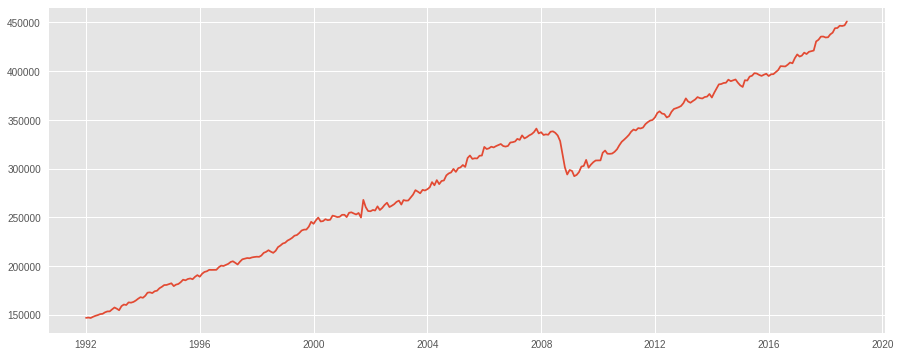

In [10]:
ts.dropna(inplace=True)
plt.plot(ts)

## Identificação de Anomalias

### Função para deteccão de anomalias utilizando decomposição STL

In [0]:
def anomalyDetection(df, modelType, columnName):
  """ Detecta anomalias em uma Serie Temporal usando uma decomposicao sazonal com medias moveis
  
  Args:
      df (Series): serie temporal
      modelType (str {"additive", "multiplicative"}): tipo do modelo a ser usado na decomposicao STLmn
      columnName: nome da coluna a ser considerada para detecção
  
  Returns:
      Um dicionario com:
        * df_anom: dataframe com as anomalias detectadas
        * plot: plot da serie temporal com as anomalias destacadas em vermelho
        * anom_share: float com o share de anomalias encontradas
  
  """
  df.dropna(inplace=True)
  if(not isinstance(df, pd.DataFrame)):
    df = df.to_frame()
    
  # Realiza decomposicao
  stl = seasonal_decompose(df[columnName], model=modelType)
   
  # Seleciona o residual da decomposicao 
  residual = stl.resid
  
  # Cria dataframe com o residual, preenche os NAs com zero
  df_resid = pd.concat([residual], axis = 1)
  df_resid.columns = ['residual']
  df_resid.fillna(0, inplace = True)
  
  # Aplica o Z-score Modificado
  median = np.median(df_resid['residual'])
  MAD = np.median(abs(df_resid['residual'] - median))
  df_resid['Mi'] = 0.6745*(df_resid['residual'] - median) / MAD
  df_resid['outlier'] = np.where(((df_resid['Mi']>3.5) | (df_resid['Mi']<-3.5)), df[columnName], 0)
  df['outlier'] = np.where(((df_resid['Mi']>3.5) | (df_resid['Mi']<-3.5)), df[columnName], 0)
  df_anom = df_resid[(df_resid['outlier'] != 0)]
  df_anom.drop(columns=['residual','Mi'], inplace=True)
  
  # Calcula share de anomalias na serie temporal
  #anom_share = df_anom.shape[0] / ts.shape[0]
  anom_share = df_anom.shape[0] / df.shape[0]

  # Tratamento do Plot
  fig, ax = plt.subplots()
  df[columnName].plot(color = 'red', linestyle='dashed', linewidth = 0.5, x=ax)
  df_anom['outlier'].plot(style='bo', ax=ax)

  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.title('Value vs Time | '+ str("{0:.2f}%".format(float(anom_share) * 100)) + ' de Anomalias')
  plt.subplots_adjust(bottom=0.2)

  fig = plt.gcf()
  fig.set_size_inches(15, 7)
  
  return{"df_anom": df_anom, "plot": fig, "anom_share": anom_share}

###Função para substituir outliers por interpolação

In [0]:
def treatAnomaly(df, seriesColumn, outlierColumn, typeTecnique):
  """ Substitui as anomalias pela tecnica escolhida (media, rollingmean, interpolacao)
  
  Args:
      df (Dataframe): dataframe com a coluna seriesColumn (serie temporal) e outlierColumn
      seriesColumn (str): nome da coluna do df com a serie temporal
      outlierColumn (str): nome da coluna do df com os outliers (1 para outliers, 0 caso contrario)
      typeTecnique (str {"interp", "rollmean3", "average"}): tecnica da interpolacao a ser utilizada
  
  Returns:
      df (Dataframe): dataframe com os outliers substituidos pela tecnica de interpolacao utilizada
  
  """
  
  # Calcula media com valor anterior e posterior ao ponto da anomalia
  df['previous'] = df[seriesColumn].shift(1)
  df['posterior'] = df[seriesColumn].shift(-1)
  df['average'] = (df['previous'] + df['posterior']) / 2
  
  # Media da rolling window de tamanho 3
  df['rollmean3']  = df[seriesColumn].rolling(3,center=True,min_periods=1).mean()

  # Adiciona Nan onde tem outlier
  df[seriesColumn] = np.where(df[outlierColumn]==1, np.NaN, df[seriesColumn])
  
  df['interp']  = df[seriesColumn].interpolate()
  df[seriesColumn] = np.where(df[outlierColumn]==1, df[typeTecnique], df[seriesColumn])
  df.drop(columns=['outlier','previous','posterior','average', 'rollmean3','interp'], inplace=True)
  return df

### Verifica se a serie temporal possui anomalias

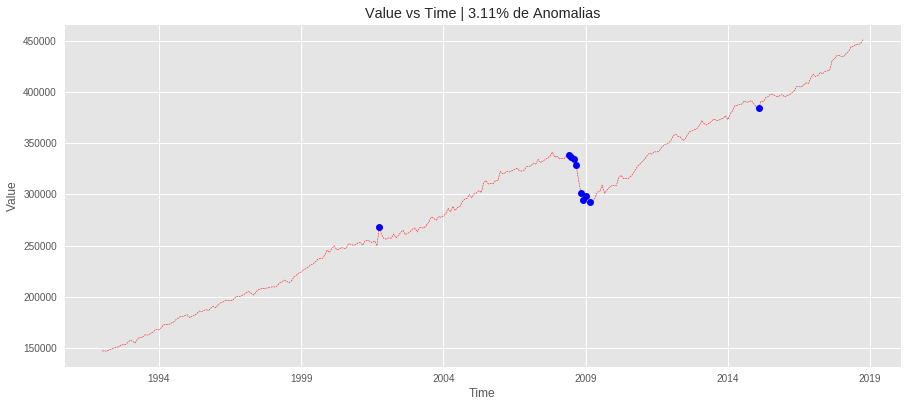

In [23]:
dictAnomaly = anomalyDetection(ts, 'additive', 'value')
fig = dictAnomaly["plot"]

df_anom = dictAnomaly["df_anom"]

### Remove as anomalias e substitui por interpolação

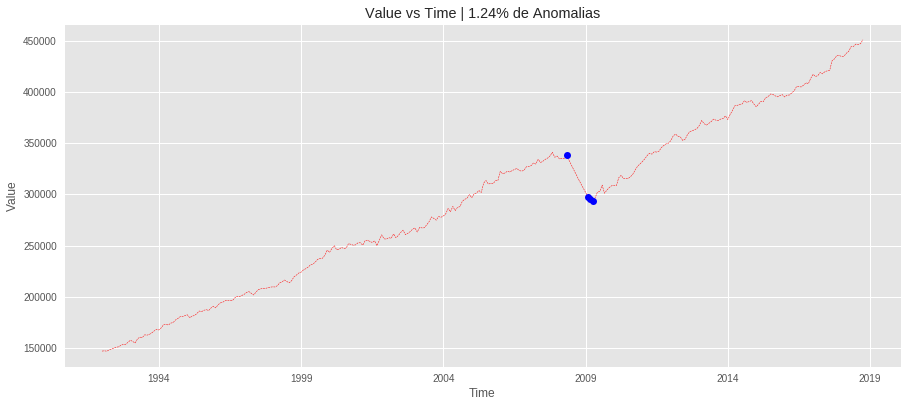

In [14]:
df_anom['outlier'] = 1
df = ts.to_frame()
df = pd.concat([df, df_anom], axis = 1)
df['outlier'].fillna(0, inplace=True)

df_treated = treatAnomaly(df, 'value', 'outlier', 'interp')
dictAnomaly2 = anomalyDetection(df_treated, 'additive')


Transforma para o formato series original

In [0]:
df_treated.drop(columns='outlier', inplace=True)
ts = df_treated.iloc[:,0]

## Decomposição [DEPRECATED]

###Eliminar Tendência

A tendência é identificada quando há uma tendência significante positiva/negativa. Para reduzir uma tendência, aplica-se uma transformação que penaliza valores muito elevados. Como fazer? Aplicar **log, raíz quadrada, raíz cúbica**

O plot abaixo do log não mostra muita diferença. Seguimos sem aplicar o log.

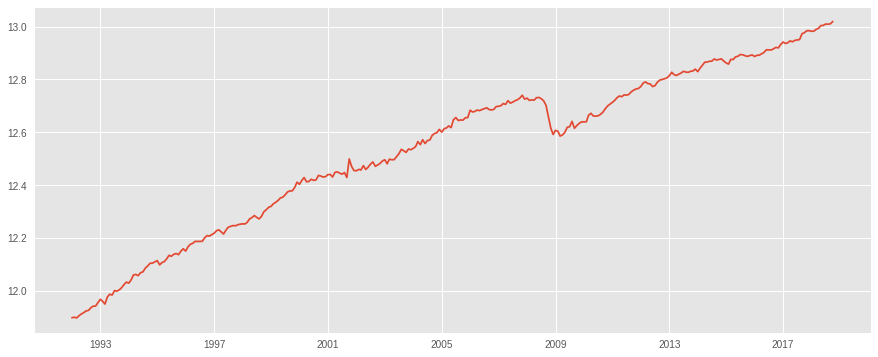

In [0]:
ts.dropna(inplace=True)
ts_log = np.log(ts)
plt.plot(ts_log)

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    expweighted_avg = pd.ewma(timeseries, halflife=12) # exponentially weighted moving average
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    expweighted = plt.plot(expweighted_avg, color='green', label = 'Avg Expweighted')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

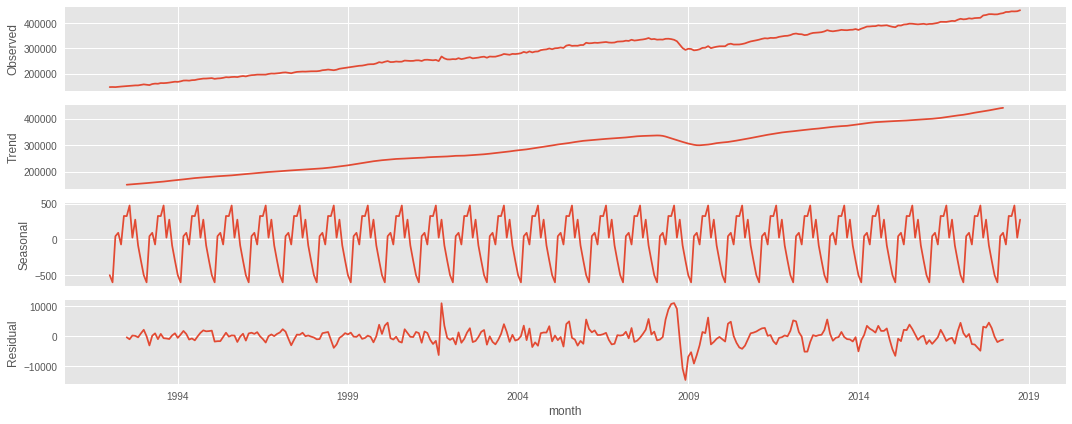

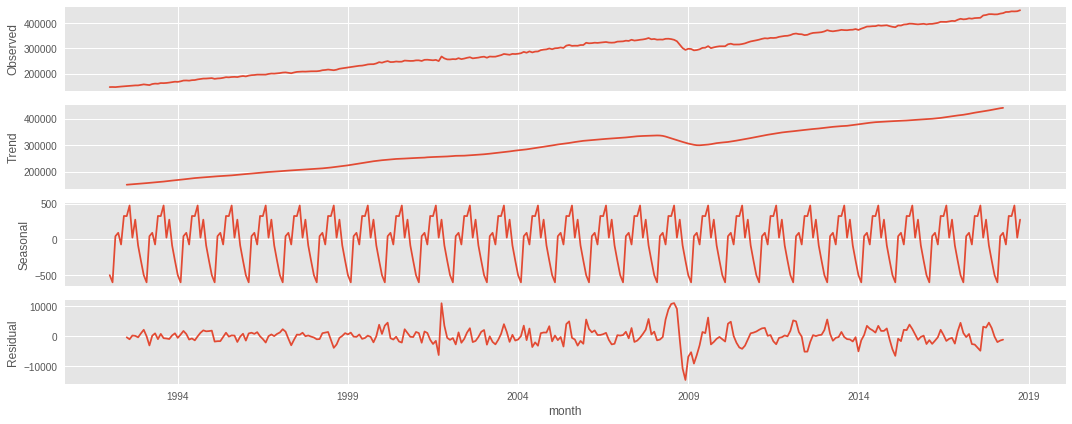

In [0]:
decomposition = seasonal_decompose(ts, model='additive')
decomposition.plot()

### Eliminar Tendência e Sazonalidade

Existem várias técnicas para eliminar tendência e sazonalidade. Abaixo vamos abordar algumas delas: residual do residual_decompose().

Interpretação dos resultados do teste de Dickey-Fuller:

Se o **Test Statistic** for menor que o Critical Value (5%), podemos dizer com 95% de confiança que a série é estacionária.

**1. Decomposição usando residual** do seasonal_decompose()



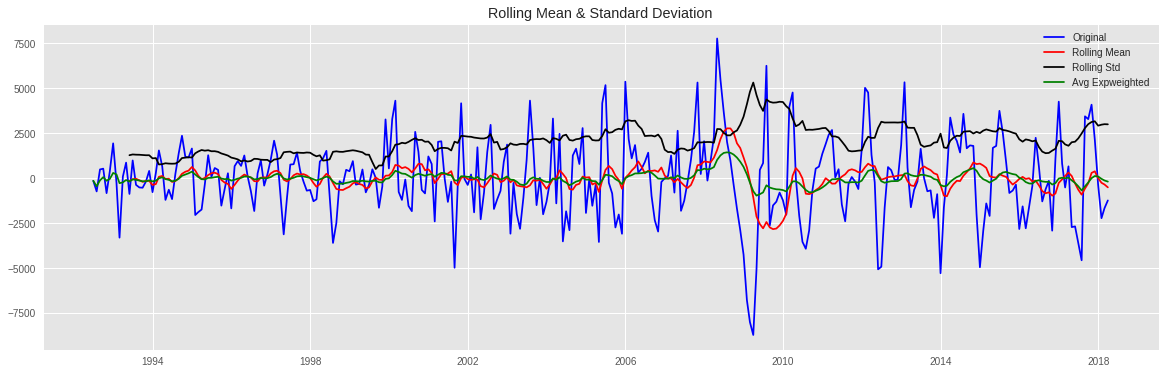

Results of Dickey-Fuller Test:
Test Statistic                -9.945967e+00
p-value                        2.589181e-17
#Lags Used                     3.000000e+00
Number of Observations Used    3.060000e+02
Critical Value (1%)           -3.451902e+00
Critical Value (5%)           -2.871032e+00
Critical Value (10%)          -2.571827e+00
dtype: float64


In [0]:
residual = decomposition.resid
residual.dropna(inplace=True)
test_stationarity(residual)

**2. Diferenciação**: diferença com um time lag. É a diferença entre um instante particular com o instante anterior. Abaixo temos uma diferenciação de 1ª ordem.

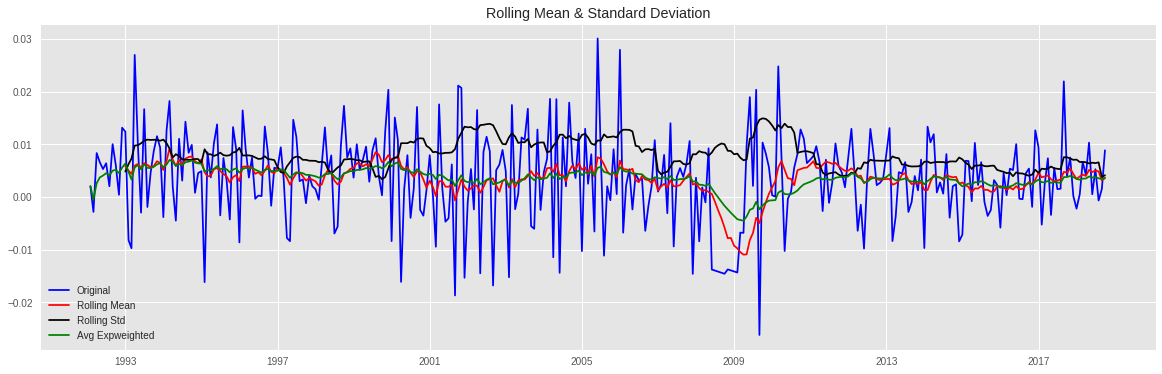

Results of Dickey-Fuller Test:
Test Statistic                  -4.127403
p-value                          0.000872
#Lags Used                      11.000000
Number of Observations Used    309.000000
Critical Value (1%)             -3.451691
Critical Value (5%)             -2.870939
Critical Value (10%)            -2.571778
dtype: float64


In [0]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True) # para não dar erro de não convergimento
test_stationarity(ts_log_diff)

**3. Exponentially weighted moving average**: Os pesos são assinalados a todos os valores anteriores por um fator de decaimento.

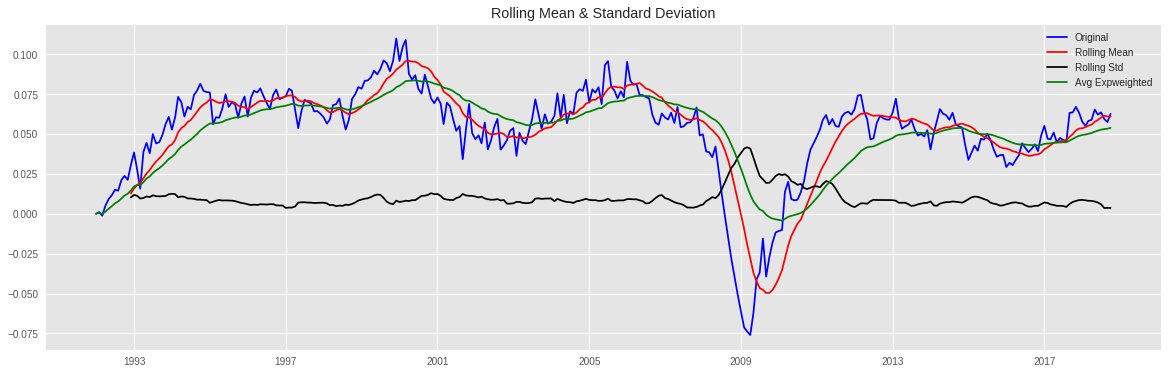

Results of Dickey-Fuller Test:
Test Statistic                  -2.582878
p-value                          0.096588
#Lags Used                       1.000000
Number of Observations Used    320.000000
Critical Value (1%)             -3.450952
Critical Value (5%)             -2.870615
Critical Value (10%)            -2.571605
dtype: float64


In [0]:
# Exponentially weighted moving average
expweighted_avg = pd.ewma(ts_log, halflife=12)
ts_ewma_diff = ts_log - expweighted_avg
ts_ewma_diff.dropna(inplace=True)
test_stationarity(ts_ewma_diff)

### Forecasting a Time Series

In [0]:
ts_diff.dropna(inplace=True) # para não dar erro de não convergimento
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [0]:
#Plot ACF (para achar parâmetro d - onde cruza o limiar de confiança superior)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF (para achar parâmetro p - onde cruza o limiar de confiança superior)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## Implementação ARIMA

Considero dados somente após 2009, para evitar a queda devido à crise de 2008.

In [0]:
ts = ts['2009':'2018']

### Funcao para determinar o ARIMA com menor AIC, dado uma combinacao dos parametros p, d, q

In [0]:
def evaluateArima(dataset, p_values, d_values, q_values):
  """ Verifica qual a combinacao de parametros p, d, q do ARIMA que minimizam o AIC
  
  Args:
      dataset (Series): serie temporal
      p_values (int): range da permutacao do parametro p
      d_values (int): range da permutacao do parametro d
      q_values (int): range da permutacao do parametro q
  
  Returns:
      mod.fit() do Arima dos parametros p, d, q que resultaram no menor AIC
  
  """
  p = range(0, p_values)
  d = range(0, d_values)
  q = range(0, q_values)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  best_aic, best_result, best_param, best_param_seasonal = float("inf"), float("inf"), None, None
  for param in pdq:
    for param_seasonal in seasonal_pdq:
      try:
        mod = sm.tsa.statespace.SARIMAX(dataset,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        if results.aic < best_aic:
           best_aic, best_result, best_param, best_param_seasonal = results.aic, results, param, param_seasonal
        #print('AIC:{} - ARIMA{}x{}12'.format(results.aic, param, param_seasonal))
      except:
            continue
  print('Menor AIC: %.3f - ARIMA%sx%s' % (best_aic, best_param, best_param_seasonal))
  #print('Menor AIC:{} - ARIMA{}x{}12'.format(best_aic, best_param, best_param_seasonal))
  return best_result
  

### Resultados do ARIMA

In [0]:
results = evaluateArima(ts, 2, 2, 2)

Menor AIC: 1717.948 - ARIMA(1, 1, 1)x(1, 1, 1, 12)


In [0]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8857      0.065     13.620      0.000       0.758       1.013
ma.L1         -0.9794      0.078    -12.554      0.000      -1.132      -0.826
ar.S.L12      -0.3550      0.227     -1.566      0.117      -0.799       0.089
ma.S.L12      -0.0252      0.181     -0.140      0.889      -0.380       0.329
sigma2      1.028e+07   1.26e-08   8.19e+14      0.000    1.03e+07    1.03e+07


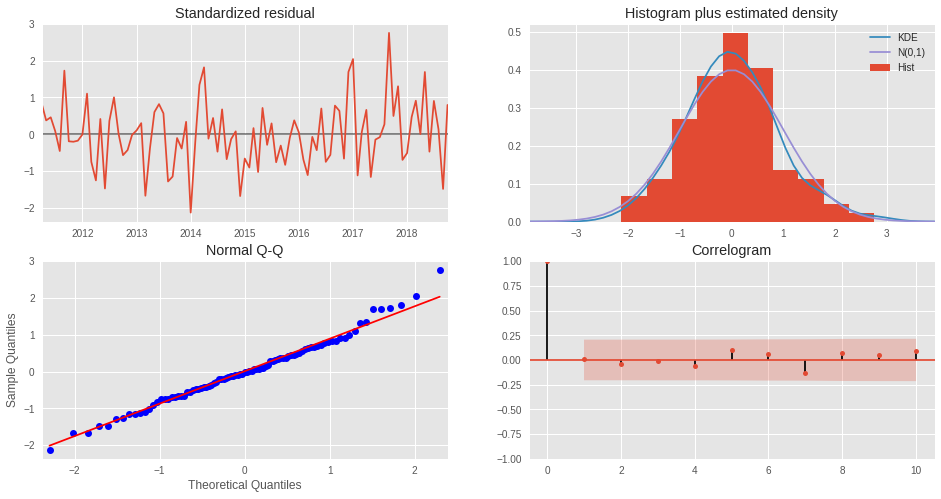

In [0]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Previsao em dados existentes

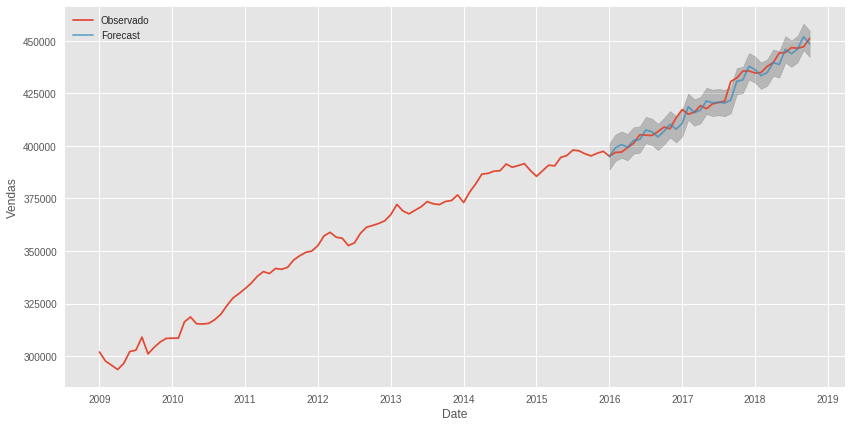

In [0]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int() # limites superior e inferior dos erros

ax = ts['1992':].plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Vendas')
plt.legend()

plt.show()

### Calcula erro sobre a previsao

In [0]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['2014-01-01':]

# Erro quadratico medio
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('Erro quadratico medio da previsao {}'.format(round(mse, 2)))

# Raiz do erro quadratico medio
rmse = np.sqrt(mse)
print('Raiz do erro quadratico medio da previsao {}'.format(round(rmse, 2)))

Erro quadratico medio da previsao 9988910.59
Raiz do erro quadratico medio da previsao 3160.52


### Elabora o Forecast

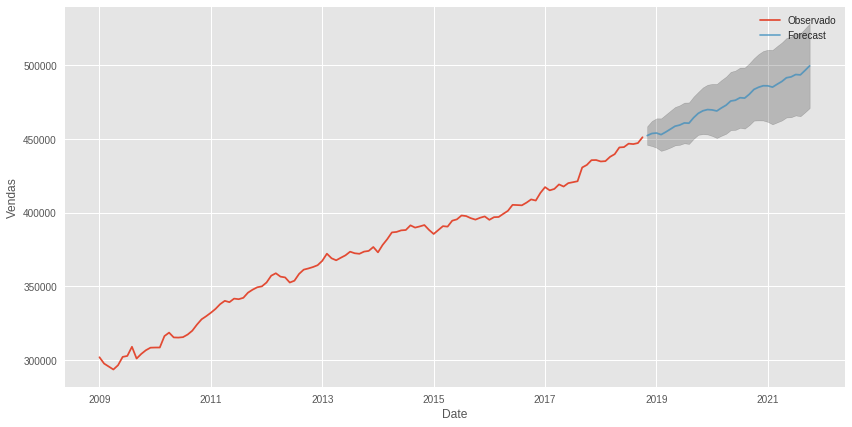

In [0]:
# get_prediction vs get_forecast: trazem o mesmo output, o que muda sao os parametros da funcao
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()

ax = ts.plot(label='Observado')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Vendas')

plt.legend()
plt.show()


### Saída com valores previstos, limiares inferior e superior

In [0]:
pred_uc.predicted_mean
predicted = pd.DataFrame({'date':pred_uc.predicted_mean.index, 'previsto':pred_uc.predicted_mean.values})
predicted.set_index('date', inplace=True)

pred_uc_ci = pred_uc.conf_int(alpha=0.05) #  dataFrame de intervalos com 95% de confiança
previsto = pd.concat([predicted,pred_uc_ci], axis=1)

previsto.head()

,previsto,lower value,upper value
date,,,
2018-11-01,452165.115349,445879.244758,458450.985941
2018-12-01,453585.879389,445100.654275,462071.104504
2019-01-01,453914.785042,443973.155620,463856.414464
2019-02-01,452821.270839,441815.916907,463826.624770
2019-03-01,454588.247203,442768.036264,466408.458141
